<a href="https://colab.research.google.com/github/juramireza/Introducci-n-a-la-inteligencia-artificial/blob/main/Suicide_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align=center>Detección de tendencias suicidas mediante el análisis de twweets con BERT y TensorFlow</h2>

En este cuaderno de colab se realiza la clasificación de noticias falsas, con base en BERT y con el conjunto de datos que se encuentra en https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch

##1: Importar Tensor flow

### Instalación de tensor flow

In [1]:
import tensorflow as tf
print(tf.version.VERSION)

2.8.2


In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

In [3]:
# Instalar requerimientos para utilizar el repositorio de tensorflow models
!pip install -Uqr models/official/requirements.txt
# Reiniciar el entorno de ejecución y volver a correr hasta acá

In [4]:
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Reiniciar entorno de ejecución

**Nota** 
Después de instalar los paquetes anteriores, reiniciar entorno de ejecución y volver a cargarlos. 



##2. Importar librerías

In [5]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
import transformers
from transformers import BertModel, BertTokenizer
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
import seaborn as sns # Para realización de gráficos
import matplotlib.pyplot as plt # Para realización de gráficos
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import Model, load_model #Creación y cargue del modelo
from transformers import pipeline

In [6]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.8.2
Eager mode:  True
GPU is available


##3.Montar el drive y cargar el  conjunto de datos con pandas 

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('/content/gdrive/MyDrive/Proyecto de NLP/Proyecto_NLP_Suicide_Detection/Suicide_Detection.csv',low_memory=False)
df.shape

(232074, 3)

In [10]:
#Imprimir los últimos 20 registros
df.tail(12)

Unnamed: 0                                               text  \
232062      348092  paralyzing anxiety &amp; depression are pushin...   
232063      348094  i have a cute ribbon tied around my neck and m...   
232064      348096  How ba-a-ad can i be? I’m just doin’ what come...   
232065      348097  I know no one here cares but anyways I was fig...   
232066      348098  My mom tried to kill herself today. I feel los...   
232067      348100  I’m a fucking scummy person and I can’t change...   
232068      348101  I did something today I went sledding with my ...   
232069      348103  If you don't like rock then your not going to ...   
232070      348106  You how you can tell i have so many friends an...   
232071      348107  pee probably tastes like salty tea😏💦‼️ can som...   
232072      348108  The usual stuff you find hereI'm not posting t...   
232073      348110  I still haven't beaten the first boss in Hollo...   

              class  
232062      suicide  
232063  non-suicide  
232064  non-suicide  
232065  non-suicide  
232066      suicide  
232067      suicide  
232068  non-suicide  
232069  non-suicide  
232070  non-suicide  
232071  non-suicide  
232072      suicide  
232073  non-suicide

In [11]:
#Función para quitar espacios y convertir en mayúsculas 
def limpieza(columna):
  x=columna.strip()
  y=x.upper()
  return y

df['class']=df['class'].apply(limpieza)
df['target'] = np.where(df['class']=='SUICIDE', 1, 0)
df=df[['text','class','target']]
df

text        class  target
0       Ex Wife Threatening SuicideRecently I left my ...      SUICIDE       1
1       Am I weird I don't get affected by compliments...  NON-SUICIDE       0
2       Finally 2020 is almost over... So I can never ...  NON-SUICIDE       0
3               i need helpjust help me im crying so hard      SUICIDE       1
4       I’m so lostHello, my name is Adam (16) and I’v...      SUICIDE       1
...                                                   ...          ...     ...
232069  If you don't like rock then your not going to ...  NON-SUICIDE       0
232070  You how you can tell i have so many friends an...  NON-SUICIDE       0
232071  pee probably tastes like salty tea😏💦‼️ can som...  NON-SUICIDE       0
232072  The usual stuff you find hereI'm not posting t...      SUICIDE       1
232073  I still haven't beaten the first boss in Hollo...  NON-SUICIDE       0

[232074 rows x 3 columns]

In [12]:
#Definir tipo de dato de las columnas
df = df.astype({'text': 'str','class': 'str','target': 'int64'})

(232074, 3)

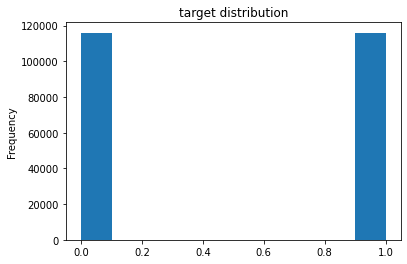

In [13]:
#Revisar la cantidad de noticias verdaderes (1) y falsas (0)
df.target.plot(kind='hist', title='target distribution')
df.shape

## 3: Crear conjuntos de datos, de entrenamiento, validación y test

In [14]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.9, stratify=df.target.values)
valid_df, remaining2 = train_test_split(remaining, random_state=42, train_size=0.5, stratify=remaining.target.values)
test_df, _  = train_test_split(remaining2, random_state=42, train_size=0.9, stratify=remaining2.target.values)

train_df.shape, valid_df.shape, test_df.shape

((208866, 3), (11604, 3), (10443, 3))

In [15]:
test_df[:10432]

text        class  target
175284  Recurring urgesI’ve been feeling useless for q...      SUICIDE       1
141786  Can’t provide for my family, skill-less, in de...      SUICIDE       1
73472   No one will care if I dieEveryday I have a sup...      SUICIDE       1
2674    You can’t be insulted if you don’t understand ...  NON-SUICIDE       0
43972   I'm so scared Frick, just found out that I'm g...  NON-SUICIDE       0
...                                                   ...          ...     ...
60809   i need help, i was raped by two older men.2 mo...      SUICIDE       1
103796  I GOT THEM OFF!!! I have had braces for about ...  NON-SUICIDE       0
10945   Contemplated suicide a lot in the last monthMy...      SUICIDE       1
174926  i hate myself and i wanna die emotional trauma...  NON-SUICIDE       0
109348  a link for a video that is not a rickroll. thi...  NON-SUICIDE       0

[10432 rows x 3 columns]

###Convertir los conjuntos de datos a  tf.data.Dataset

In [16]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['text'].values, train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df['text'].values, valid_df['target'].values))
  test_data =  tf.data.Dataset.from_tensor_slices((test_df['text'].values, test_df['target'].values)) 
  for text, label in train_data.take(5):
    print(text)
    print(label)  

tf.Tensor(b'Most of the "gifted" kids now have at least one mental illness. Telling a kid that they\'re gifted is basically like "wow you\'re only 11 and you already lost half your serotonin", change my mind That being said, what is your diagnosis bro?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'Leading someone on is worse than rejecting them Even ghosting someone is better then leading them on, so to any of u mfs leading on multiple people either ghost them or tell them ur not interested for me pls', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b"I Am A MistakeI'll never have friends. I'll never have a gf. I'll never be employed by anyone. I'll never make anyone proud. I'll never succeed at anything. I'll never be anything other then a fat grotesque slob nobody wants to be seen dead with. I'll never have amazing experiences. I'll never travel to amazing places. \nI'm sure, for most people, it gets better. They find people in their

## 4: Descargar el modelo preentrenado BERT

In [17]:
"""
Cada registro del conjunto de datos se compone, del texto y de su etiqueta
- El procesamiento de datos, consiste en transformar el texto a:
input_word_ids, input_mask, segment_ids que son los elementos de entrada del modelo BERT. 
- La tokenización de los textos se hace mendiante el tokenizador del modelo BERT.
"""
 # Etiquetas de las categorías
 # 1 - Noticia verdadera
 # 0 - Noticia false
label_list = [0,1]

 # Definición del tamaño del token
max_seq_length = 128
#Definición del tamaño del lote
train_batch_size = 32

# Carga del modelo preentrenado y el tokenizador del modelo 
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [18]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [19]:
 tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

##6. Definición de funciones de tokenización y procesamiento del texto para el modelo BERT

In [20]:
# La siguientes funciones convierte el texto en features de entrada con su respectiva etiqueta

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [21]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text,label], Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])
  x = {'input_words_ids' : input_ids,
       'input_mask': input_mask,
       'input_type_id': segment_ids
       }  
  return (x, label_id)

##7. Definir los conjuntos, de train, validation y test

In [22]:
with tf.device('/cpu:0'):
  # Data de entrenamiento
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)        
  .prefetch(tf.data.experimental.AUTOTUNE))

  # Data de validación
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)        
  .prefetch(tf.data.experimental.AUTOTUNE))

  #Data de prueba
  test_data = (test_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)        
  .prefetch(tf.data.experimental.AUTOTUNE))

In [25]:
# Especificaciones de la data de entrenamiento
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_id': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_words_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [26]:
#Especificaciones de la data de validación
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_id': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_words_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [27]:
#Especificaciones de la data de test
test_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_id': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_words_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

##8. Construcción de la cabeza del modelo, para que realice la clasificación

In [28]:
# Construyendo la capa personalizada del modelo
def create_model():
  input_words_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_words_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
  input_type_id = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_id")
  pooled_output, sequence_output = bert_layer([input_words_ids, input_mask, input_type_id])
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop)
  model = tf.keras.Model(
           inputs = {
               'input_words_ids': input_words_ids,
               'input_mask': input_mask,
               'input_type_id': input_type_id          
           },
           outputs = output )
  return model

##9. Entrenamiento del modelo de clasificación de tendencias suicidas

In [29]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_words_ids (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_id (InputLayer)     [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_words_ids[0][0]',        
                                 (None, 128, 768)]                'input_mask[0][0]',         

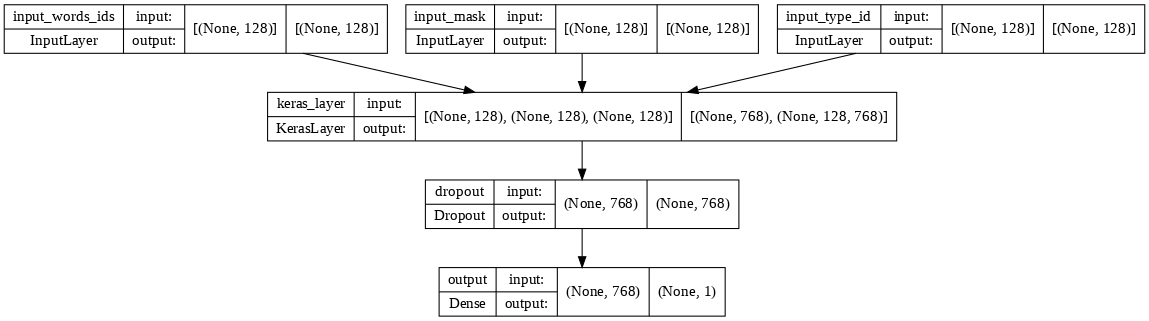

In [30]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

#10.Generación de checkpoints

In [31]:
# Usar la parada temprana para parar el entrenamiento si la pérdida en validación no baja después de un cierto número de epochs 
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Guardamos el modelo con menor error de validación
checkpointer = ModelCheckpoint(filepath="/content/gdrive/MyDrive/Proyecto NLP/Bert-weights_Clasification.hdf5", verbose=1, save_best_only=True)

#11.Verificar disponibilidad de la GPU

In [34]:
nombre_gpu = tf.test.gpu_device_name()
if nombre_gpu != '/device:GPU:0':
  raise SystemError('GPU no encontrada')
print('GPU encontrada: {}'.format(nombre_gpu))

GPU encontrada: /device:GPU:0


#12.Entrenamiento con GPU

In [ ]:
import timeit
def entrenamiento_gpu():
  with tf.device('/device:GPU:0'):
    epochs = 2
    history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1, callbacks=[checkpointer,earlystopping])
  return None

gpu_time = timeit.timeit('entrenamiento_gpu()', number=1, setup='from __main__ import entrenamiento_gpu')

#13. Cargar el modelo entrenado y evaluar la calidad 

In [35]:
model = tf.keras.models.load_model(('/content/gdrive/MyDrive/Proyecto de NLP/Proyecto_NLP_Suicide_Detection/Bert-weights_Clasification.hdf5'), custom_objects={'KerasLayer':hub.KerasLayer})

In [36]:
#Hacemos la predicción
test_predict = model.predict(test_data)

In [37]:
test_predict

array([[0.9999832 ],
       [0.99921095],
       [0.9999875 ],
       ...,
       [0.9999746 ],
       [0.03605545],
       [0.00125418]], dtype=float32)

In [38]:
# Dado que usamos la función de activación sigmoide al final, nuestro resultado contiene valores continuos de 0 a 1.
# La red se usa  para clasificar si el twwet tiene tendencias suicidas o no

predict = []

##Menor a 0.5 es porque es cero, es decir no hay tendencias suicidas
##mayor a 0.5 es porque es uno, es decir hay tendencias suicidas
for i in test_predict:
  if i < 0.5: 
    predict.append(0)
  else:
    predict.append(1)

predict = np.asarray(predict)

In [39]:
len(predict)

10432

In [40]:
# 
original = np.asarray(test_df.target)[:10432]
len(original)


10432

In [41]:
# Buscamos la accuracy del modelo
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(original, predict)
accuracy

0.970954754601227

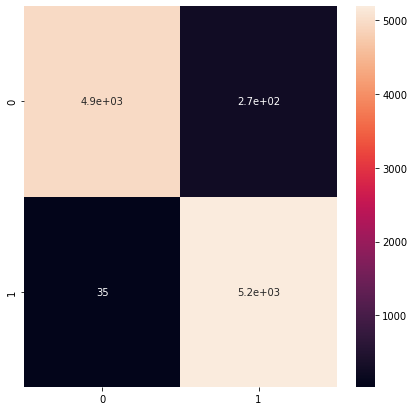

In [42]:
# Representamos la matriz de confusión
import seaborn as sns # Para realización de gráficos
import matplotlib.pyplot as plt # Para realización de gráficos
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)
plt.show()

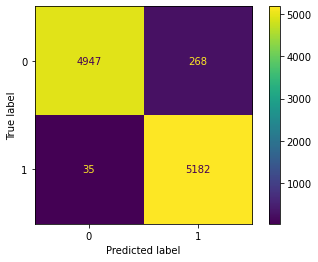

In [43]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
ConfusionMatrixDisplay.from_predictions(original, predict)
plt.show()

In [44]:
# Imprimimos el reporte de clasificación
from sklearn.metrics import classification_report
report = classification_report(original,predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      5215
           1       0.95      0.99      0.97      5217

    accuracy                           0.97     10432
   macro avg       0.97      0.97      0.97     10432
weighted avg       0.97      0.97      0.97     10432



#14.Pruebas en inglés

In [45]:
tweet='Recurring urgesI’ve been feeling useless for quite some time now. I haven’t done anything with my life. I always do something wrong, but it’s never something I can fix. I’m just ultimately a fuck up. No one I know genuinely likes me. Everyone around me only acts through pity. I have a razor blade in my dresser that I think about using everyday. I tried to help change a friends tire and while I was out there on the highway I couldn’t help but think how easy it would be for me to just walk forward a few steps and be gone. The only thing that stopped me was the fact that my sister was present. No one knows I have these urges, and I want to get help so that when I do it my family can at least know they tried to help. I owe them that. I can’t show anyone affection so all I do is push everyone away. And when I do open up and become vulnerable I’m always hurt because of it. Those few instances of vulnerability have only ever happened when I’m drunk. I try to open up. I have one friend that cares about me deeply and was there for me last night when I wasn’t in the best place. But he has no idea about my suicidal tendencies. I tried to open up to another friend last night and she blew me off. Made jokes and laughed. It’s just that everything I do is pointless now. I don’t know where to go with my life and I don’t know what to do anymore. There’s no point in my life, because I know I’ll never amount to anything. I try to picture myself 5 years down the road but I can’t even do that. I honestly can’t even see myself alive for five more years because I know that I’ll act on my urges. It’s just a matter of when now.'
tweet_en_lista=[tweet]

In [46]:
test_data = tf.data.Dataset.from_tensor_slices((tweet_en_lista, [1]*len(tweet_en_lista)))
test_data = test_data.map(to_feature_map).batch(1)
preds = model.predict(test_data)
threshold = 0.5
['Suicida' if pred >= threshold else 'No Suicida' for pred in preds]

['Suicida']

#15. Pruebas traduciendo Tweets

In [47]:
import transformers
from transformers import pipeline

In [48]:
translator_sp_en = pipeline("translation", model="Helsinki-NLP/opus-mt-es-en")

Downloading:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/298M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/807k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/783k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/marian/tokenization_marian.py:198: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [61]:
tweet='Hola. Seré muy sincero con ustedes. Cuido de un hermoso gato y un precioso perro. Más allá de esos dos motivos no hay nada más por lo cual quiera seguir viviendo. Tengo resuelto que una vez esos dos seres no existan ejecutare  mi s***cidio. No hay consuelo para mí y es una decisión tomada pero necesito aguantar mientras tanto así que quiero conocer un poco de sus vidas y entender cómo logran ser resilientes cada día para incorporarlo a mí rutina para luchar algunos años más por seguir vivo por el motivo arriba mencionado. Los leeré atentamente. Gracias'
tweet_traslate=translator_sp_en(tweet)
tweet_traslate=tweet_traslate[0]['translation_text']
tweet_en_lista=[tweet_traslate]

In [62]:
test_data = tf.data.Dataset.from_tensor_slices((tweet_en_lista, [1]*len(tweet_en_lista)))
test_data = test_data.map(to_feature_map).batch(1)
preds = model.predict(test_data)
threshold = 0.5
['Suicida' if pred >= threshold else 'No Suicida' for pred in preds]

['Suicida']

In [63]:
preds

array([[0.9996333]], dtype=float32)

In [64]:
tweet=" ¿Qué harían o qué consejos o cómo procederían ustedes cuando a sus casi 27 años ya se ha cambiado casi de tres carreras, es un ser completamente frustrado, lleno de desgracias, de vergiienzas, donde la familia y tus personas cercanas imaginan que estás en condiciones perfectas e incluso creen que ya estás a punto de graduarte porque les has mentido y les dices que todo está bien, pero que en realidad faltan como tres años, y que, además esto posiblemente haya sido una consecuencia porque durante los últimos diez años vienes afrontando un cuadro clínico de depresión que no lo han dejado avanzar, donde no se siente y se le descubre gusto realmente a las cosas, que en los últimos meses ha contemplado el sui-..cidio quizás como una opción? Donde no te consideras dentro del marco social, donde te resulta inevitable compararte con las personas q a esta edad ya han logrado grandes cosas, alguien a esta edad con carrera profesional, con experiencia, ganando al menos un salario... Qué casos de superación personal han escuchado frente a estos casos? Estoy cansado de soportar esta presión, toda esta farsa, quisiera volver a empezar de cero, como hacerle una reseteada leerlos y escucharlos todas sus recomendaciones. Y gracias por leer las desgracias de este sujeto"
tweet_traslate=translator_sp_en(tweet)
tweet_traslate=tweet_traslate[0]['translation_text']
tweet_en_lista=[tweet_traslate]

In [65]:
test_data = tf.data.Dataset.from_tensor_slices((tweet_en_lista, [1]*len(tweet_en_lista)))
test_data = test_data.map(to_feature_map).batch(1)
preds = model.predict(test_data)
threshold = 0.5
['Suicida' if pred >= threshold else 'No Suicida' for pred in preds]

['Suicida']

In [66]:
preds

array([[0.98878]], dtype=float32)

In [85]:
tweet="No soy muy feliz con mi vida, pero amo a mi familia y me gusta pasar tiempo con ellos"
tweet_traslate=translator_sp_en(tweet)
tweet_traslate=tweet_traslate[0]['translation_text']
tweet_en_lista=[tweet_traslate]

In [86]:
test_data = tf.data.Dataset.from_tensor_slices((tweet_en_lista, [1]*len(tweet_en_lista)))
test_data = test_data.map(to_feature_map).batch(1)
preds = model.predict(test_data)
threshold = 0.5
['Suicida' if pred >= threshold else 'No Suicida' for pred in preds]

['No Suicida']

In [87]:
preds

array([[0.17188784]], dtype=float32)